In [52]:
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

#### load datasets and split training data

In [ ]:
with h5py.File('mnist_testdata.hdf5', 'r') as f:
    x_test = np.array(f['xdata'])
    y_test = np.array(f['ydata'])

with h5py.File('mnist_traindata.hdf5', 'r') as f:
    x_train = np.array(f['xdata'])
    y_train = np.array(f['ydata'])

split = 10000
x_val, y_val = x_train[:split, :], y_train[:split, :]
x_train, y_train = x_train[split:, :], y_train[split:, :]

print(f"shape of x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"shape of x_test: {x_test.shape}, y_test: {y_test.shape}")
print(f"shape of x_train: {x_train.shape}, y_train: {y_train.shape}")

shape of x_val: (10000, 784), y_val: (10000, 10)
shape of x_test: (10000, 784), y_test: (10000, 10)
shape of x_train: (50000, 784), y_train: (50000, 10)


#### define all the utility functions needed

In [179]:
# compute accuracy
def compute_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# compute loss (neg log-loss)
def compute_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1)) 

#### possible activation functions

In [255]:
class Activation:
    def activation(self, x):
        raise NotImplementedError
    def derivative(self, x, a):
        raise NotImplementedError
    
class ReLU(Activation):
    def __init__(self):
        super().__init__()
    def activation(self, x):
        return np.maximum(0, x)
    def derivative(self, x, a):
        return (x > 0).astype(float)
    
class LeakyReLU(Activation):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    def activation(self, x):
        return np.where(x > 0, x, self.alpha * x)
    def derivative(self, x, a):
        return np.where(x > 0, 1, self.alpha)
    
class ELU(Activation):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    def activation(self, x):
        return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))
    def derivative(self, x, a):
        return np.where(x > 0, 1, self.alpha * np.exp(x))

class Sigmoid(Activation):
    def __init__(self):
        super().__init__()
    def activation(self, x):
        return 1 / (1 + np.exp(-x))
    def derivative(self, x, a):
        return a * (1 - a)

class Tanh(Activation):
    def __init__(self):
        super().__init__()
    def activation(self, x):
        return np.tanh(x)
    def derivative(self, x, a):
        return 1 - a ** 2

#### layer definition. code is based on this lecture: https://www.youtube.com/watch?v=Ih5Mr93E-2c&list=PLD63A284B7615313A&index=10

In [256]:
class HiddenLayer:
    def __init__(self, input_dim, output_dim, activation: Activation):
        self.in_dim = input_dim
        self.out_dim = output_dim
        self.activation = activation
        self.bias = np.zeros((1, self.out_dim))
        self.weights = 0.10 * np.random.randn(self.in_dim, self.out_dim)

    def forward(self, inputs):
        self.inputs = np.array(inputs)
        assert self.in_dim == self.inputs.shape[1]
        self.signals = np.dot(self.inputs, self.weights) + self.bias
        self.signals = np.clip(self.signals, -100, 100)
        self.outputs = self.activation.activation(self.signals)
    
    def calculate_delta(self, weights, deltas):
        partial = np.dot(deltas, weights.T)
        derivative = self.activation.derivative(self.signals, self.outputs)
        self.deltas = partial * derivative
    
    def backward(self, learning_rate = 0.01):
        self.weights = self.weights - learning_rate * np.dot(self.inputs.T, self.deltas)
        self.bias = self.bias = learning_rate * np.sum(self.deltas, axis=0, keepdims=True)

class FinalLayer:
    def __init__(self, input_dim, num_classes):
        self.in_dim = input_dim
        self.out_dim = num_classes
        self.bias = np.zeros((1, self.out_dim))
        self.weights = 0.10 * np.random.randn(self.in_dim, self.out_dim)
        
    def softmax(self):
        exp_logits = np.exp(self.signals - np.max(self.signals, axis=1, keepdims=True))
        probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probabilities
    
    def forward(self, inputs):
        self.inputs = np.array(inputs)
        assert self.in_dim == self.inputs.shape[1]
        self.signals = np.dot(self.inputs, self.weights) + self.bias
        self.signals = np.clip(self.signals, -100, 100)
        self.outputs = self.softmax()

    def calculate_delta(self, output_true):
        assert self.out_dim == output_true.shape[1]
        self.deltas = self.outputs - output_true
    
    def backward(self, learning_rate = 0.01):
        self.weights = self.weights - learning_rate * np.dot(self.inputs.T, self.deltas)
        self.bias = self.bias = learning_rate * np.sum(self.deltas, axis=0, keepdims=True)

#### build a MLP network

In [ ]:
class Net:
    def __init__(self, input_dim, hidden_dims, output_dim, act_fn, learning_rate = 0.01):
        prev_dim = input_dim
        self.hidden_layers = []
        self.learning_rate = learning_rate
        for dim in hidden_dims:
            self.hidden_layers.append(HiddenLayer(prev_dim, dim, act_fn))
            prev_dim = dim
        self.final = FinalLayer(prev_dim, output_dim)

    def decay_learning_rate(self):
        self.learning_rate = self.learning_rate / 2

    def forward(self, x):
        for layer in self.hidden_layers:
            layer.forward(x)
            x = layer.outputs
        self.final.forward(x)
    
    def backward(self, y_true):
        self.final.calculate_delta(y_true)
        next_weights = self.final.weights
        next_deltas = self.final.deltas

        for layer in reversed(self.hidden_layers):
            layer.calculate_delta(next_weights, next_deltas)
            next_weights = layer.weights
            next_deltas = layer.deltas

        self.final.backward(self.learning_rate)
        for layer in reversed(self.hidden_layers):
            layer.backward(self.learning_rate)

    def predict(self, x):
        self.forward(x)
        return self.final.outputs

#### model training

In [251]:
def train(net, x_train, y_train, x_val, y_val, batch_size = 100, epochs = 30):
    train_accs, val_accs = [], []
    sample_train_size = len(x_train)

    # predicting on train data
    y_pred = net.predict(x_train)
    train_acc = compute_accuracy(y_pred, y_train)
    train_accs.append(train_acc)

    # predicting on val data
    y_pred = net.predict(x_val)
    val_acc = compute_accuracy(y_pred, y_val)
    val_accs.append(val_acc)
    val_loss = compute_loss(y_pred=y_pred, y_true=y_val)
    print(f"prior to training validation loss: {val_loss}, validation accuracy: {val_acc}")

    for epoch in range(epochs):
        if epoch in [10, 15]:
            net.decay_learning_rate()
            
        for batch in range(0, sample_train_size, batch_size):
            x_batch = x_train[batch : batch + batch_size]
            y_batch = y_train[batch : batch + batch_size]

            net.forward(x_batch)
            net.backward(y_batch)
        
        # predicting on train data
        y_pred = net.predict(x_train)
        train_acc = compute_accuracy(y_pred, y_train)
        train_accs.append(train_acc)

        # predicting on val data
        y_pred = net.predict(x_val)
        val_acc = compute_accuracy(y_pred, y_val)
        val_accs.append(val_acc)
        val_loss = compute_loss(y_pred=y_pred, y_true=y_val)
        if epoch % 5 == 0:
            print(f"validation loss: {val_loss}, validation accuracy: {val_acc}")

    return train_accs, val_accs

def plot(acc_train, acc_val):
    plt.figure(figsize=(12, 5))
    plt.plot(acc_train, label='train accuracy')
    plt.plot(acc_val, label='val accuracy')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('training accuracy')
    plt.show()

#### Sigmoid()

prior to training validation loss: 2.3618325599394905, validation accuracy: 0.098
validation loss: 0.30504370437646927, validation accuracy: 0.9099
validation loss: 0.12219610964027151, validation accuracy: 0.9663
validation loss: 0.1049670021393997, validation accuracy: 0.9737
validation loss: 0.10779598648907149, validation accuracy: 0.9745


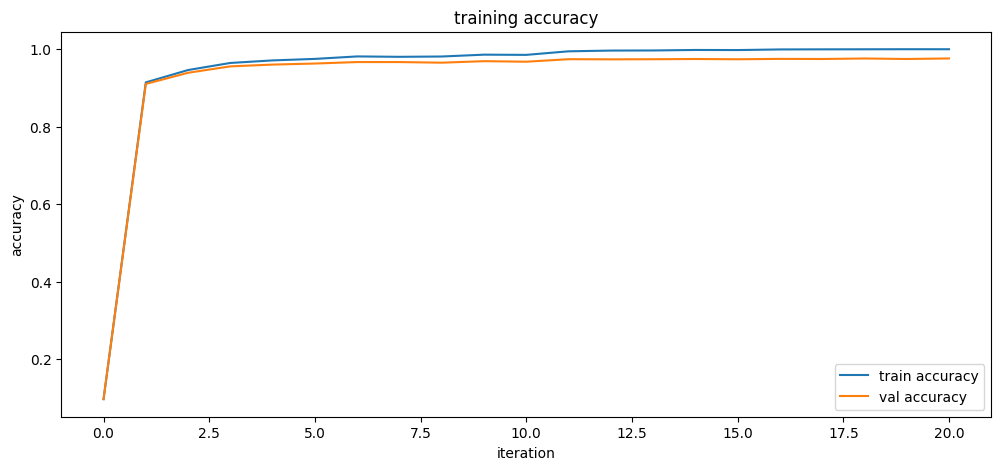

prior to training validation loss: 2.339889785752715, validation accuracy: 0.107
validation loss: 0.6449659802747391, validation accuracy: 0.7943
validation loss: 0.13962672657147954, validation accuracy: 0.9606
validation loss: 0.1105034131924496, validation accuracy: 0.9719
validation loss: 0.12204671859169143, validation accuracy: 0.9738


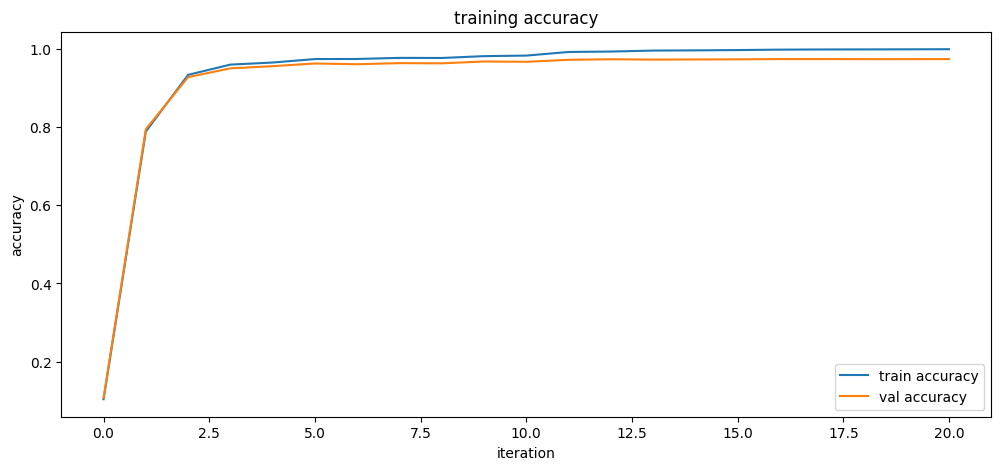

prior to training validation loss: 2.3273355357391825, validation accuracy: 0.1001
validation loss: 0.8722020876563947, validation accuracy: 0.8013
validation loss: 0.17663431371367075, validation accuracy: 0.9535
validation loss: 0.13274180852741205, validation accuracy: 0.9674
validation loss: 0.13411867905872127, validation accuracy: 0.9702


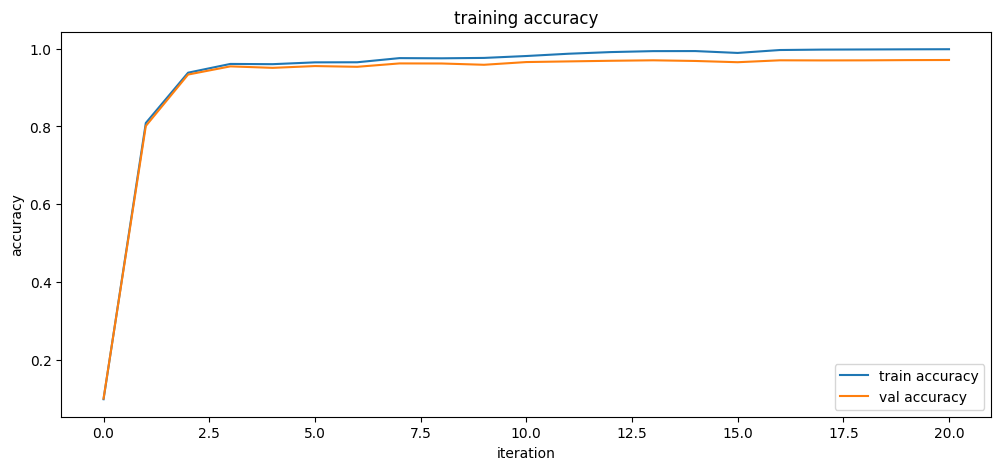

In [253]:
epochs, batch_size = 20, 100
for learning_rate in [0.04, 0.08, 0.1]: 
    net = Net(
        input_dim=784,
        hidden_dims=[100, 50, 30],
        output_dim=10,
        act_fn=Sigmoid(),
        learning_rate=learning_rate
    )

    train_accs, val_accs = train(net, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)
    plot(train_accs, val_accs)

#### TanH()

prior to training validation loss: 2.33517489156967, validation accuracy: 0.0724
validation loss: 0.23599993591207968, validation accuracy: 0.9264
validation loss: 0.14961932531698025, validation accuracy: 0.9587
validation loss: 0.1070841069988341, validation accuracy: 0.9741
validation loss: 0.11073820672350708, validation accuracy: 0.975


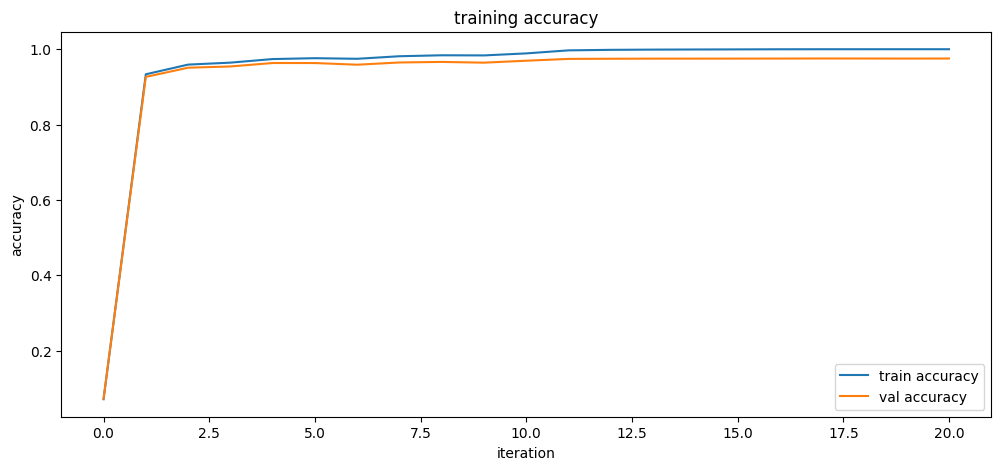

prior to training validation loss: 2.2940533807672066, validation accuracy: 0.1055
validation loss: 0.2313876469524364, validation accuracy: 0.9285
validation loss: 0.12624276317257346, validation accuracy: 0.966
validation loss: 0.1092482967095923, validation accuracy: 0.9718
validation loss: 0.1106414761281539, validation accuracy: 0.9742


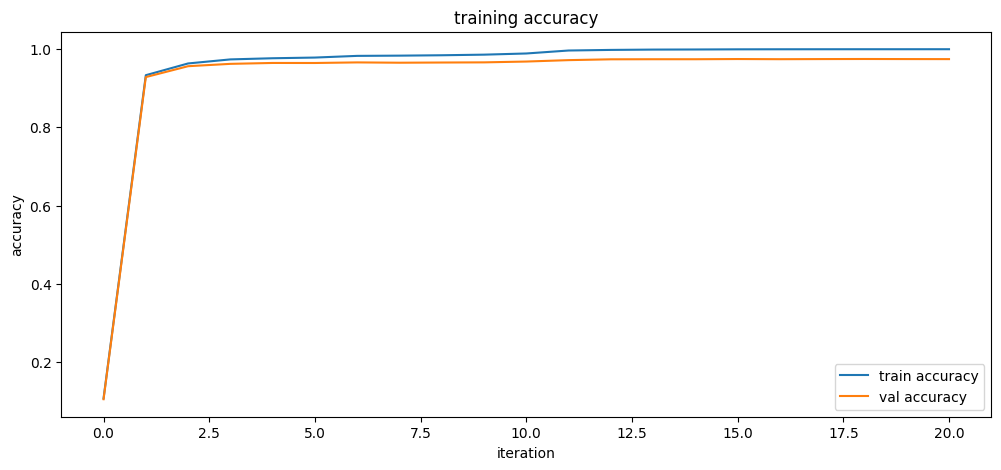

prior to training validation loss: 2.307393824447522, validation accuracy: 0.125
validation loss: 0.22234820617424858, validation accuracy: 0.9343
validation loss: 0.1212074519642368, validation accuracy: 0.9671
validation loss: 0.10844801467305358, validation accuracy: 0.9737
validation loss: 0.10960981470838153, validation accuracy: 0.975


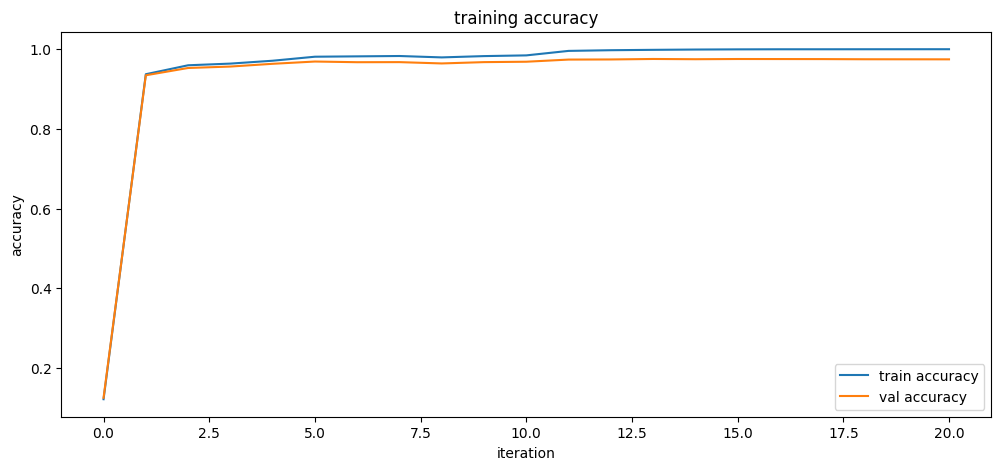

In [282]:
epochs, batch_size = 20, 100
for learning_rate in [0.006, 0.008, 0.01]: 
    net = Net(
        input_dim=784,
        hidden_dims=[100, 50, 30],
        output_dim=10,
        act_fn=Tanh(),
        learning_rate=learning_rate
    )

    train_accs, val_accs = train(net, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)
    plot(train_accs, val_accs)

#### ReLU()

prior to training validation loss: 2.3080524503597553, validation accuracy: 0.1178
validation loss: 0.25478128293337593, validation accuracy: 0.9261
validation loss: 0.12886891696036656, validation accuracy: 0.967
validation loss: 0.10544484372455093, validation accuracy: 0.9769
validation loss: 0.1213608855194072, validation accuracy: 0.9783


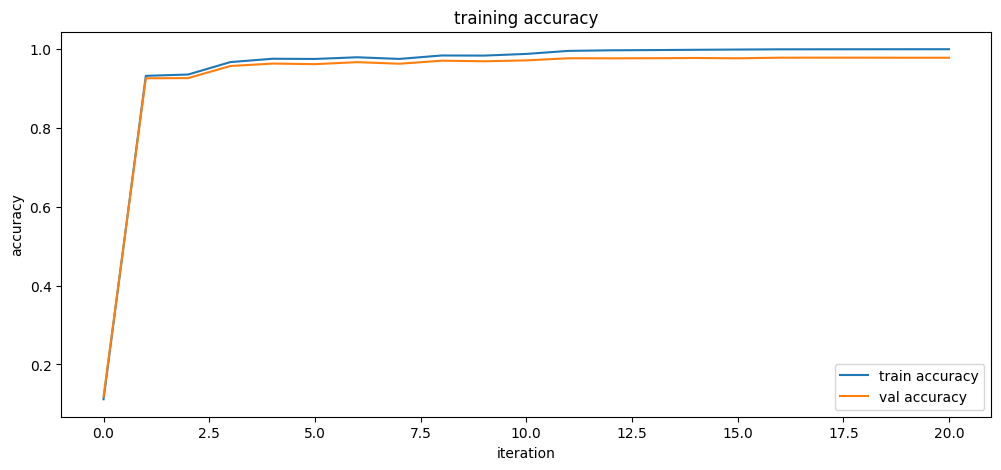

prior to training validation loss: 2.3231262873068124, validation accuracy: 0.1228
validation loss: 0.2625102906776774, validation accuracy: 0.9247
validation loss: 0.12807348345227915, validation accuracy: 0.9669
validation loss: 0.11809515737748386, validation accuracy: 0.9734
validation loss: 0.13652914094537924, validation accuracy: 0.9752


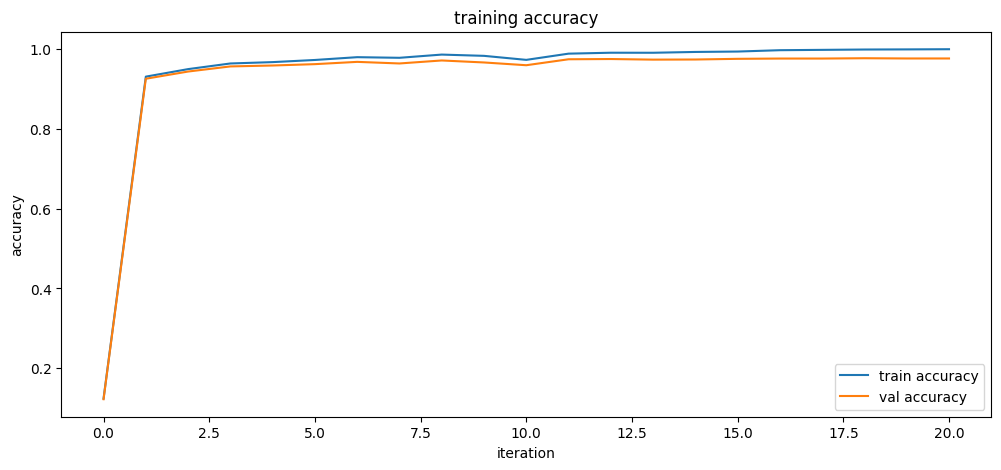

prior to training validation loss: 2.305481446951812, validation accuracy: 0.0792
validation loss: 0.3914355848318818, validation accuracy: 0.8945
validation loss: 0.19068787498689665, validation accuracy: 0.9492
validation loss: 0.13216245972711435, validation accuracy: 0.9677
validation loss: 0.13722463560916526, validation accuracy: 0.9704


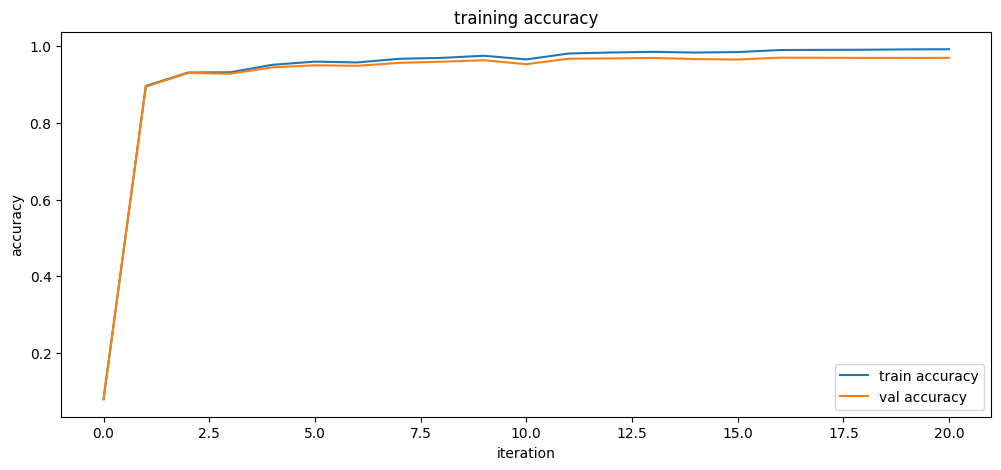

In [274]:
epochs, batch_size = 20, 100
for learning_rate in [0.006, 0.008, 0.01]: 
    net = Net(
        input_dim=784,
        hidden_dims=[100, 50, 30],
        output_dim=10,
        act_fn=ReLU(),
        learning_rate=learning_rate
    )

    train_accs, val_accs = train(net, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)
    plot(train_accs, val_accs)

#### LeakyReLU()

prior to training validation loss: 2.3090326818527704, validation accuracy: 0.1024
validation loss: 0.2531839282511624, validation accuracy: 0.9197
validation loss: 0.12429042398038423, validation accuracy: 0.9653
validation loss: 0.11513626847263202, validation accuracy: 0.9717
validation loss: 0.11311630800453136, validation accuracy: 0.9731


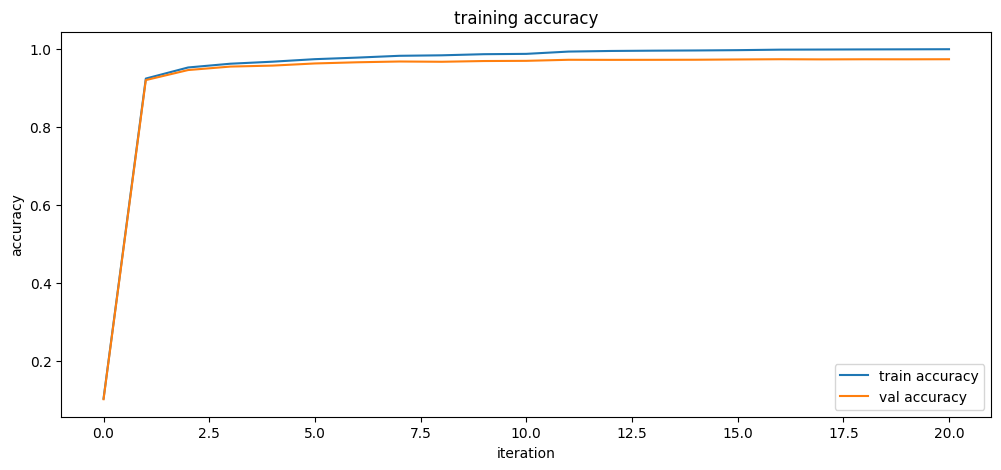

prior to training validation loss: 2.308225576321566, validation accuracy: 0.103
validation loss: 0.24119672490485522, validation accuracy: 0.9227
validation loss: 0.14955912735891433, validation accuracy: 0.9591
validation loss: 0.11466880613677817, validation accuracy: 0.9758
validation loss: 0.12080379293211302, validation accuracy: 0.9778


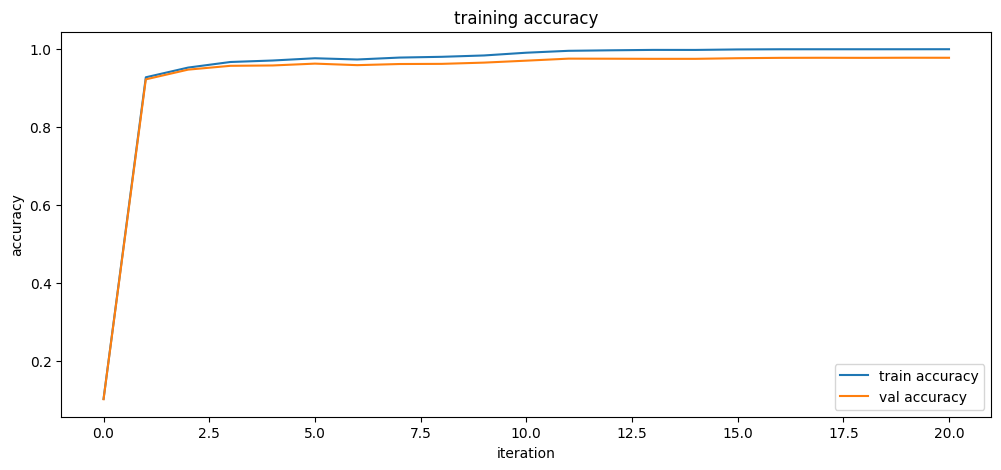

prior to training validation loss: 2.3023601090194954, validation accuracy: 0.0962
validation loss: 0.21451747789436149, validation accuracy: 0.9368
validation loss: 0.12404232584065489, validation accuracy: 0.968
validation loss: 0.10607706934953305, validation accuracy: 0.9768
validation loss: 0.12563126923313273, validation accuracy: 0.9782


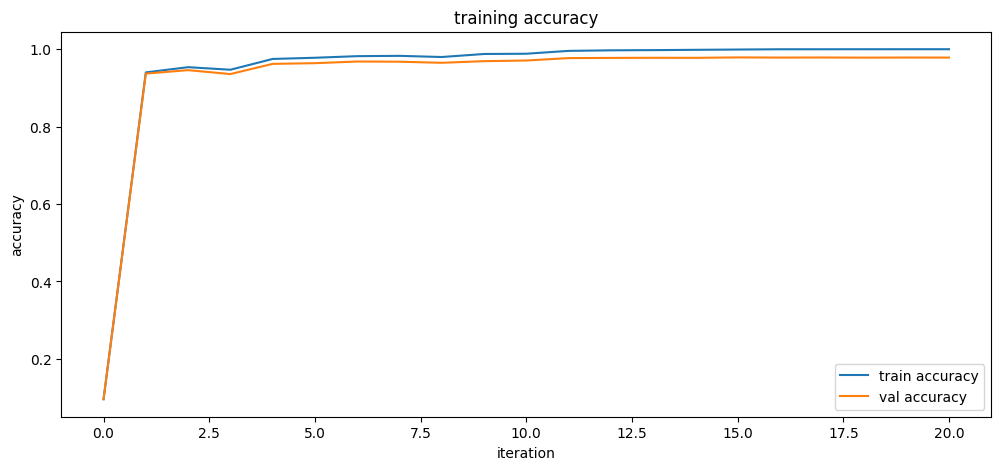

In [277]:
epochs, batch_size = 20, 100
for learning_rate in [0.002,0.004, 0.006]: 
    net = Net(
        input_dim=784,
        hidden_dims=[100, 50, 30],
        output_dim=10,
        act_fn=LeakyReLU(),
        learning_rate=learning_rate
    )

    train_accs, val_accs = train(net, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)
    plot(train_accs, val_accs)

#### ELU()

prior to training validation loss: 2.347021467714843, validation accuracy: 0.1028
validation loss: 0.2736282614470313, validation accuracy: 0.9112
validation loss: 0.11708007050324575, validation accuracy: 0.9654
validation loss: 0.0971955178388799, validation accuracy: 0.9729
validation loss: 0.09961015887567652, validation accuracy: 0.9743


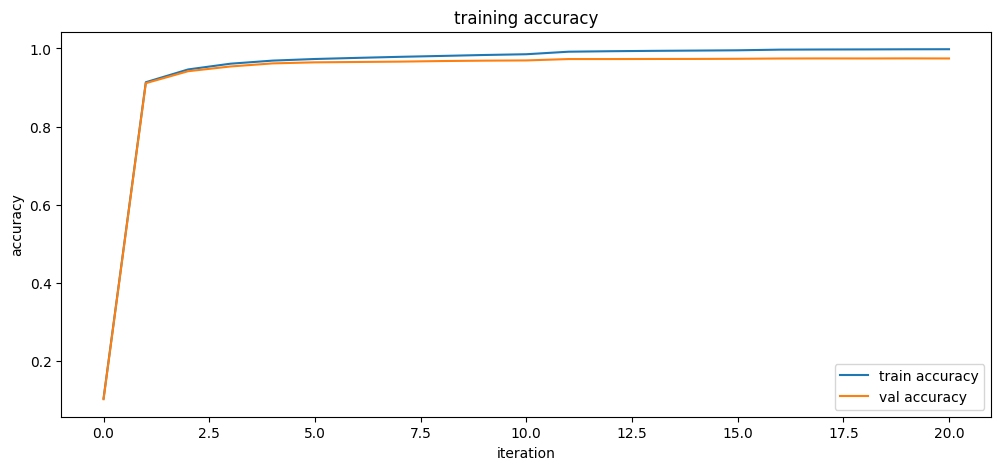

prior to training validation loss: 2.320916533626163, validation accuracy: 0.1278
validation loss: 0.31968631784665297, validation accuracy: 0.9023
validation loss: 0.1428173309024333, validation accuracy: 0.9583
validation loss: 0.10074747932015946, validation accuracy: 0.9754
validation loss: 0.10667258914481026, validation accuracy: 0.9778


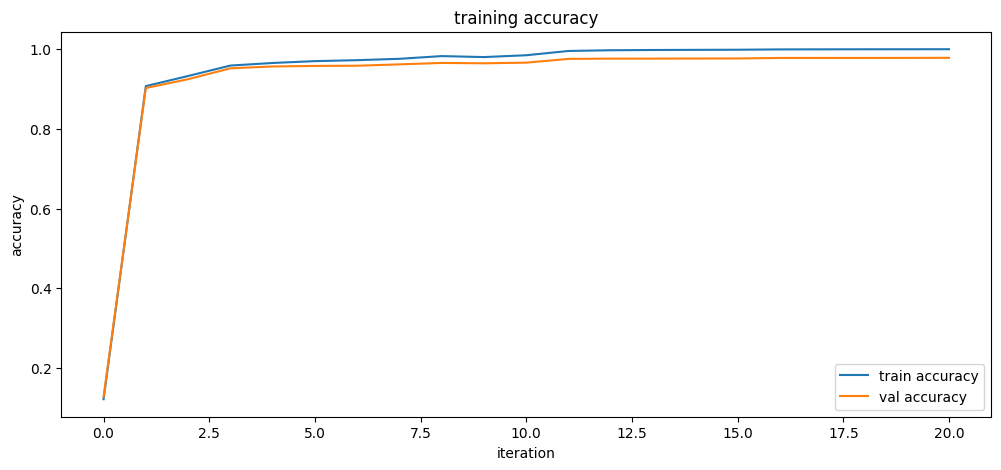

prior to training validation loss: 2.287674476761802, validation accuracy: 0.1065
validation loss: 0.5936130397854615, validation accuracy: 0.8666
validation loss: 0.11560791670775991, validation accuracy: 0.9711
validation loss: 0.10470226147633846, validation accuracy: 0.9772
validation loss: 0.1156239616722674, validation accuracy: 0.9799


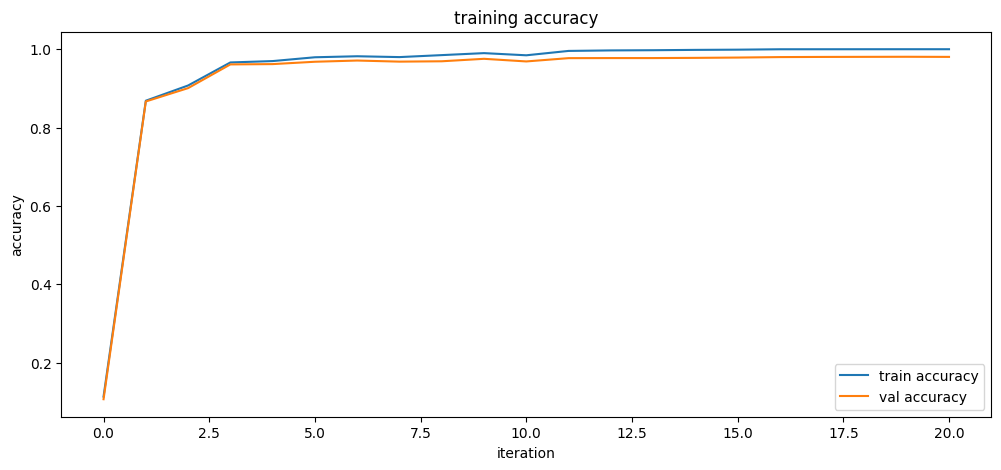

In [278]:
epochs, batch_size = 20, 100
for learning_rate in [0.002,0.004, 0.006]: 
    net = Net(
        input_dim=784,
        hidden_dims=[100, 50, 30],
        output_dim=10,
        act_fn=ELU(),
        learning_rate=learning_rate
    )

    train_accs, val_accs = train(net, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)
    plot(train_accs, val_accs)

#### Best model is with ELU activation functions and learning rate 0.006

In [280]:
net = Net(
    input_dim=784,
    hidden_dims=[100, 50, 30],
    output_dim=10,
    act_fn=LeakyReLU(),
    learning_rate=0.006
)

train_accs, val_accs = train(net, x_train, y_train, x_val, y_val, batch_size=batch_size, epochs=epochs)
# test accuracy
y_pred = net.predict(x_test)
test_acc = compute_accuracy(y_pred, y_test)
print(f"test accuracy is: {test_acc * 100}, training accuracy: {train_accs[-1] * 100 }, validation accuracy: {val_accs[-1] * 100 }")

prior to training validation loss: 2.307024048718314, validation accuracy: 0.133
validation loss: 0.27441700104596956, validation accuracy: 0.9166
validation loss: 0.12768853539511243, validation accuracy: 0.9681
validation loss: 0.11583573651560346, validation accuracy: 0.9763
validation loss: 0.12781498732585792, validation accuracy: 0.9777
test accuracy is: 97.74000000000001, training accuracy: 99.97, validation accuracy: 97.84
